<a href="https://colab.research.google.com/github/RoyElkabetz/Text-Summarization-with-Deep-Learning/blob/main/notebooks/Text_Classification_full_vs_machine_summarized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing results of text classifier over summarized IMDB datasets

In this notebook we compare the results of text classification of a simple embedding-bag based text classifier (as in Pytorch tutorial) over different length summarized IMDB datasets.

This note book contains:
- Loading the datasets - train, valid, test ($\clubsuit$ with sampling), test ($\clubsuit$without sampling).
- Print some examples.
- Training a text classifier.
- Compare model performence over test sets.

$\clubsuit$ **Sampling** (with / without) - in the summarization process we can use a random sampling of next word based on the word conditional probabilities output by the model ([explained here](https://huggingface.co/blog/how-to-generate)). So, with / without in that sense discribes if we used (or not) sampling in the summary generation process. 




In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Text-Summarization-with-Deep-Learning
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Text-Summarization-with-Deep-Learning/src")

Cloning into 'Text-Summarization-with-Deep-Learning'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 393 (delta 210), reused 53 (delta 17), pack-reused 0
Receiving objects: 100% (393/393), 8.71 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [2]:
## uncomment if you want to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# link to summarized IMDB datasets
!gdown --id '1EJD8f_PiymNmhaDuvxj27qTo2OMMruiP' -O 'train.csv'
!gdown --id '1--t5cZIL81qBOLjbHxj6iDeXUez5zAvV' -O 'valid.csv'
!gdown --id '1-2-nT7vtLNMoiUMXuLcWp2wdCryIS9Ep' -O 'test_with_sampling.csv'
!gdown --id '1-3SD5xYj_R8VaxT15NWs_HbnR5tz7fmP' -O 'test_without_sampling.csv'

Downloading...
From: https://drive.google.com/uc?id=1EJD8f_PiymNmhaDuvxj27qTo2OMMruiP
To: /content/train.csv
33.5MB [00:01, 33.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--t5cZIL81qBOLjbHxj6iDeXUez5zAvV
To: /content/valid.csv
31.4MB [00:01, 24.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2-nT7vtLNMoiUMXuLcWp2wdCryIS9Ep
To: /content/test_with_sampling.csv
4.06MB [00:00, 19.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3SD5xYj_R8VaxT15NWs_HbnR5tz7fmP
To: /content/test_without_sampling.csv
4.02MB [00:00, 15.2MB/s]


In [4]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     |████████████████████████████████| 2.2MB 7.6MB/s 
     |████████████████████████████████| 901kB 34.5MB/s 
     |████████████████████████████████| 3.3MB 50.4MB/s 
     |████████████████████████████████| 839kB 7.6MB/s 
     |████████████████████████████████| 829kB 23.4MB/s 
     |████████████████████████████████| 276kB 37.1MB/s 
     |████████████████████████████████| 122kB 41.8MB/s 
     |████████████████████████████████| 235kB 40.0MB/s 
     |████████████████████████████████| 1.3MB 40.3MB/s 
     |████████████████████████████████| 143kB 50.9MB/s 
     |████████████████████████████████| 296kB 52.5MB/s 


In [5]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import json


import torch
from torchtext.datasets import IMDB
import torchtext.data as data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch import nn

import utils
import models



print(f'torch {torch.__version__}')
print('Device properties:')
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_data = torch.cuda.get_device_properties(0)
    gpu_name = gpu_data.name
    gpu_mem  = f'{gpu_data.total_memory * 1e-9:.02f} Gb'
    print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
else:
    device = torch.device("cpu")
    print('CPU')

torch 1.9.0+cu102
Device properties:
GPU: Tesla T4
Memory: 15.84 Gb


# Display data
---
## Get the IMDB dataset and create a vocabulary from the train dataset


In [6]:
tokenizer = get_tokenizer('basic_english')
train_iter = IMDB(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<sos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:00<00:00, 87.7MB/s]


## Create text and labels pipelines

In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 0 if x=='neg' else 1

## Print some random samples and the size of the dataset
---

In [9]:
train_iter = IMDB(split='train')
n_samples = len(train_iter)
random_list = torch.randint(0, n_samples - 1, (4, ))
labels = []
for i, (label, text) in enumerate(train_iter):
    labels.append(label)
    if i in random_list:
        print(f'Label: {label_pipeline(label)}')
        print(f'Text: {text}')
        print(f'Split: {tokenizer(text)}')
        print(f'Tokens: {text_pipeline(text)}\n')
print('TRAIN DATASET:')
print('Number of classes: {}'.format(len(set(labels))))
print('Number of samples: {}'.format(n_samples))

Label: 0
Text: I saw this movie the other night. I can't even begin to express how much this movie sucked. The writing, the voice acting, even the claymation. Terrible, Terrible, Terrible. It's like watching 24 hours of C-Span for the sake of comedy. It just doesn't work. It literally falls flat at about every spot possible.<br /><br />Also, the movie's animation is very poor quality. I know that this is an movie made by one person, but to think that he could make 97 minutes worth of crap, maybe he could at least make 1 second worth of funny.<br /><br />This show may take the cake for being the worst film of all time. Yikes. It really was that bad. If you're looking for a movie that will make you laugh, steer clear from this abomination. My advice: Don't even buy it, or look it up for that matter. Your brain will than you.
Split: ['i', 'saw', 'this', 'movie', 'the', 'other', 'night', '.', 'i', 'can', "'", 't', 'even', 'begin', 'to', 'express', 'how', 'much', 'this', 'movie', 'sucked', 

In [13]:
TRAIN_DATASET_PATH = '/content/train.csv'
VALID_DATASET_PATH = '/content/valid.csv'
TEST_WITHsampling_DATASET_PATH = '/content/test_with_sampling.csv'
TEST_WITHOUTsampling_DATASET_PATH = '/content/test_without_sampling.csv'

# get the test set (with sampling in the T5 summarization process)
all_test_datasets_with_sampling = pd.read_csv(TEST_WITHsampling_DATASET_PATH)
all_test_datasets_with_sampling = all_test_datasets_with_sampling.drop(['Unnamed: 0', 'summary-120', 'summary-110'], axis=1)
all_test_datasets_with_sampling.head()

,label,text,summary-100,summary-90,summary-80,summary-70,summary-60,summary-50,summary-40,summary-30,summary-20
0,neg,"If you are in search of a masochistic thrill, ...","A movie that is just plane lame, but there's n...","Rent this movie, and show it to a group of you...","A movie that is rated 'Grim"" or ""Spookies"", ha...","A movie that is rated 'Grim"" or ""Spookies"", wh...",A film about a man's death that is funny as he...,"A movie that is rated 'Grim"" or ""Spookies"", wh...","A movie that is rated 'Grim"" or ""Spookies"", wh...","Rent this movie, and show it to a group of you...",A movie about a man's death that is funny as h...
1,neg,I can not believe I even wasted a NetFlix rent...,"The Stepfather film, which was released on DVD...",A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,"A video of the film 'The Stepfather', which wa...",A very sad thing to think classics like The St...,"The Stepfather film, which was released on DVD...","The Stepfather, which is released on DVD, has ...","The Stepfather film, which was released on DVD..."
2,pos,"As a big Dostoyevsky fan, I had always been di...","Actor Yul Brynner, who played a Russian Major ...","Yul Brynner, who played a dwarf Russian office...","Yul Brynner, who played a conflicted Russian o...","Actor Yul Brynner, who played a Russian Major ...","Actor Yul Brynner, who played a Russian Major ...","Actor Yul Brynner, who played a conflicted Rus...","Yul Brynner, who played a conflicted Russian o...","Actor Yul Brynner, who played a Russian Major ...","Actor Yul Brynner, who played a conflicted Rus..."
3,pos,"One of the best,Lackawanna Blues<br /><br />Gr...",The Ms Merkerson cast is extraordinary without...,"The movie 'Ms. Merkerson, which is so good tha...",The Ms Merkerson cast is so good that when it ...,"The movie 'Ms. Merkerson, which is one of the ...",The Ms Merkerson film is one of the best movie...,The Ms Merkerson cast is so good that when it ...,The Ms Merkerson film is one of the best movie...,The Ms Merkerson cast is so good that when it ...,The Ms Merkerson cast is so good that when it ...
4,neg,The first 2/3 of this film wasn't that dissimi...,"The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which..."


In [14]:
# get the test set (without sampling in the T5 summarization process)
all_test_datasets_without_sampling = pd.read_csv(TEST_WITHOUTsampling_DATASET_PATH)
all_test_datasets_without_sampling = all_test_datasets_without_sampling.drop(['Unnamed: 0', 'summary-120', 'summary-110'], axis=1)
all_test_datasets_without_sampling.head()

,label,text,summary-100,summary-90,summary-80,summary-70,summary-60,summary-50,summary-40,summary-30,summary-20
0,neg,"If you are in search of a masochistic thrill, ...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you...","Rent this movie, and show it to a group of you..."
1,neg,I can not believe I even wasted a NetFlix rent...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...,A very sad thing to think classics like The St...
2,pos,"As a big Dostoyevsky fan, I had always been di...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus...","Actor Yul Brynner, who played a conflicted Rus..."
3,pos,"One of the best,Lackawanna Blues<br /><br />Gr...",The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...,The Ms. Merkerson film is one of the best movi...
4,neg,The first 2/3 of this film wasn't that dissimi...,"The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which...","The first 2/3 of the film 'Aztec Mummy', which..."


## Print some review and its summaries from the test sets
---
#### Test example without 'sampling' in the T5 summarization process.

In [15]:
dataframe_columns = list(all_test_datasets_without_sampling.columns)
i = 35
for item in dataframe_columns:
    print(f'#### {item} ####')
    s_text = ''
    for j, s in enumerate(all_test_datasets_without_sampling.iloc[i][item]):
        s_text += s
        # if j % 80 == 0 and j > 0:
        #       s_text += '\n' 
    print(s_text)
    print('\n')


#### label ####
neg


#### text ####
When you watch low budget horror movies as much as I do, you get to where you can tell who was involved in creating the movie, as each film-maker adds his own flavor to the cheese. Such is the case with Jack-O. When I watched this truly awful movie, I was left with the undeniable feeling that Fred Olen Ray was involved, maybe not as director but in some fashion, and as I researched, I found that I was correct. Only Fred and a handfull of others could write something this pathetic, and this movie just reeked of Fred Olen Ray. Unless you like Fred Olen Ray (and God only knows why anyone would)avoid this movie. If you're going to rent an Olen Ray pic, rent Hollywood Chainsaw Hookers, it's the only bright shining star in Olen Ray's dark cheesey universe of terrible movies.


#### summary-100 ####
Filmmaker Fred Olen Ray was involved in the creation of Jack-O, which is a horror movie that stars Fred Olen Ray. The film's producers added their own flavor t

#### Test example with 'sampling' in the T5 summarization process.


In [16]:
dataframe_columns = list(all_test_datasets_with_sampling.columns)
i = 35
for item in dataframe_columns:
    print(f'#### {item} ####')
    s_text = ''
    for j, s in enumerate(all_test_datasets_with_sampling.iloc[i][item]):
        s_text += s
        # if j % 80 == 0 and j > 0:
        #       s_text += '\n' 
    print(s_text)
    print('\n')


#### label ####
neg


#### text ####
When you watch low budget horror movies as much as I do, you get to where you can tell who was involved in creating the movie, as each film-maker adds his own flavor to the cheese. Such is the case with Jack-O. When I watched this truly awful movie, I was left with the undeniable feeling that Fred Olen Ray was involved, maybe not as director but in some fashion, and as I researched, I found that I was correct. Only Fred and a handfull of others could write something this pathetic, and this movie just reeked of Fred Olen Ray. Unless you like Fred Olen Ray (and God only knows why anyone would)avoid this movie. If you're going to rent an Olen Ray pic, rent Hollywood Chainsaw Hookers, it's the only bright shining star in Olen Ray's dark cheesey universe of terrible movies.


#### summary-100 ####
Filmmaker Fred Olen Ray was involved in the creation of Jack-O, a film that features Fred and dozensl others. The movie is based on his own taste for the chees

## Prepare the datasets, split the test data by summary length 

In [17]:
train_dataset = utils.DataFrameDataset(csv_file_path=TRAIN_DATASET_PATH, only_columns=['label', 'text'])
valid_dataset = utils.DataFrameDataset(csv_file_path=VALID_DATASET_PATH, only_columns=['label', 'text'])

summary_columns_with = ['text', 'summary-100', 'summary-90', 
                   'summary-80', 'summary-70', 'summary-60', 'summary-50', 
                   'summary-40', 'summary-30', 'summary-20']

test_datasets_with_sampling = []
for item in summary_columns_with:
    dataset_columns = ['label']
    dataset_columns.append(item)
    test_datasets_with_sampling.append(utils.DataFrameDataset(
        csv_file_path=TEST_WITHsampling_DATASET_PATH, only_columns=dataset_columns))


summary_columns_without = ['text', 'summary-100', 'summary-90', 
                   'summary-80', 'summary-70', 'summary-60', 'summary-50', 
                   'summary-40', 'summary-30', 'summary-20']

test_datasets_without_sampling = []
for item in summary_columns_without:
    dataset_columns = ['label']
    dataset_columns.append(item)
    test_datasets_without_sampling.append(utils.DataFrameDataset(
        csv_file_path=TEST_WITHOUTsampling_DATASET_PATH, only_columns=dataset_columns))

In [18]:
print(f'Train dataset size is: {len(train_dataset)}\n')
print(f'Validation dataset size is: {len(valid_dataset)}\n')

print('---- Test datasets (with sampling): ----')
for i, test_dataset in enumerate(test_datasets_with_sampling):
    print(f'Test dataset with {summary_columns_with[i]} has size of: {len(test_dataset)} reviews.')

print('\n---- Test datasets (without sampling): ----')
for i, test_dataset in enumerate(test_datasets_without_sampling):
    print(f'Test dataset with {summary_columns_without[i]} has size of: {len(test_dataset)} reviews.')    

Train dataset size is: 25000

Validation dataset size is: 24000

---- Test datasets (with sampling): ----
Test dataset with text has size of: 1000 reviews.
Test dataset with summary-100 has size of: 1000 reviews.
Test dataset with summary-90 has size of: 1000 reviews.
Test dataset with summary-80 has size of: 1000 reviews.
Test dataset with summary-70 has size of: 1000 reviews.
Test dataset with summary-60 has size of: 1000 reviews.
Test dataset with summary-50 has size of: 1000 reviews.
Test dataset with summary-40 has size of: 1000 reviews.
Test dataset with summary-30 has size of: 1000 reviews.
Test dataset with summary-20 has size of: 1000 reviews.

---- Test datasets (without sampling): ----
Test dataset with text has size of: 1000 reviews.
Test dataset with summary-100 has size of: 1000 reviews.
Test dataset with summary-90 has size of: 1000 reviews.
Test dataset with summary-80 has size of: 1000 reviews.
Test dataset with summary-70 has size of: 1000 reviews.
Test dataset with s

# Prepare and train the classifier

In [19]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device) 

In [20]:
def train(dataloader, logger):
    model.train()
    total_acc, total_loss, total_count = 0, 0, 0
    partial_acc, partial_count = 0, 0
    log_interval = 200
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # logging
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_loss += loss.item()
        total_count += label.size(0)
        partial_acc = (predited_label.argmax(1) == label).sum().item()
        partial_count = label.size(0)
        logger.log_up('train_partial_acc', partial_acc / partial_count)
        logger.log_up('train_iters', idx)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              partial_acc / partial_count))
            
            start_time = time.time()
    # logging
    logger.log_up('train_loss', total_loss / total_count)
    logger.log_up('train_acc', total_acc / total_count)

def evaluate(dataloader, logger=None):
    model.eval()
    total_acc, total_loss, total_count = 0, 0, 0
    partial_acc, partial_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            
            # logging
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_loss += loss.item()
            total_count += label.size(0)
            partial_acc = (predited_label.argmax(1) == label).sum().item()
            partial_count = label.size(0)
            

            if logger is not None:
                logger.log_up('valid_partial_acc', partial_acc / partial_count)
                logger.log_up('valid_iters', idx)
        
        if logger is not None:
            logger.log_up('valid_loss', total_loss / total_count)
            logger.log_up('valid_acc', total_acc / total_count)
    return total_acc / total_count


In [21]:
# Hyperparameters
EPOCHS = 35               # epoch
LR = 5                    # learning rate
BATCH_SIZE = 32           # batch size
N_CLASSES = 2             # positive / negatinve
VOCAB_SIZE = len(vocab)   # vocabulary size 
EMB_SIZE = 64             # embedding dimension 

# set logger
logger_list = ['train_loss', 
               'train_acc',
               'train_iters',
               'train_partial_acc',
               'valid_loss',
               'valid_acc',
               'valid_iters',
               'valid_partial_acc',
               'epochs']
logger = utils.DataLogger(logger_list)

# set the model
model = models.TextClassificationModel(VOCAB_SIZE, EMB_SIZE, N_CLASSES).to(device)

# set objective function
criterion = torch.nn.CrossEntropyLoss()

# set optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)

# get dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)



total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    logger.log_up('epochs', epoch)
    train(train_dataloader, logger)
    accu_val = evaluate(valid_dataloader, logger)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
      total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   200/  782 batches | accuracy    0.625
| epoch   1 |   400/  782 batches | accuracy    0.812
| epoch   1 |   600/  782 batches | accuracy    0.844
-----------------------------------------------------------
| end of epoch   1 | time: 32.58s | valid accuracy    0.813 
-----------------------------------------------------------
| epoch   2 |   200/  782 batches | accuracy    0.656
| epoch   2 |   400/  782 batches | accuracy    0.750
| epoch   2 |   600/  782 batches | accuracy    0.719
-----------------------------------------------------------
| end of epoch   2 | time: 32.04s | valid accuracy    0.671 
-----------------------------------------------------------
| epoch   3 |   200/  782 batches | accuracy    0.844
| epoch   3 |   400/  782 batches | accuracy    0.969
| epoch   3 |   600/  782 batches | accuracy    0.844
-----------------------------------------------------------
| end of epoch   3 | time: 31.93s | valid accuracy    0.853 
-------------------------------

# Plot training logger

Text(0, 0.5, 'Accuracy [%]')

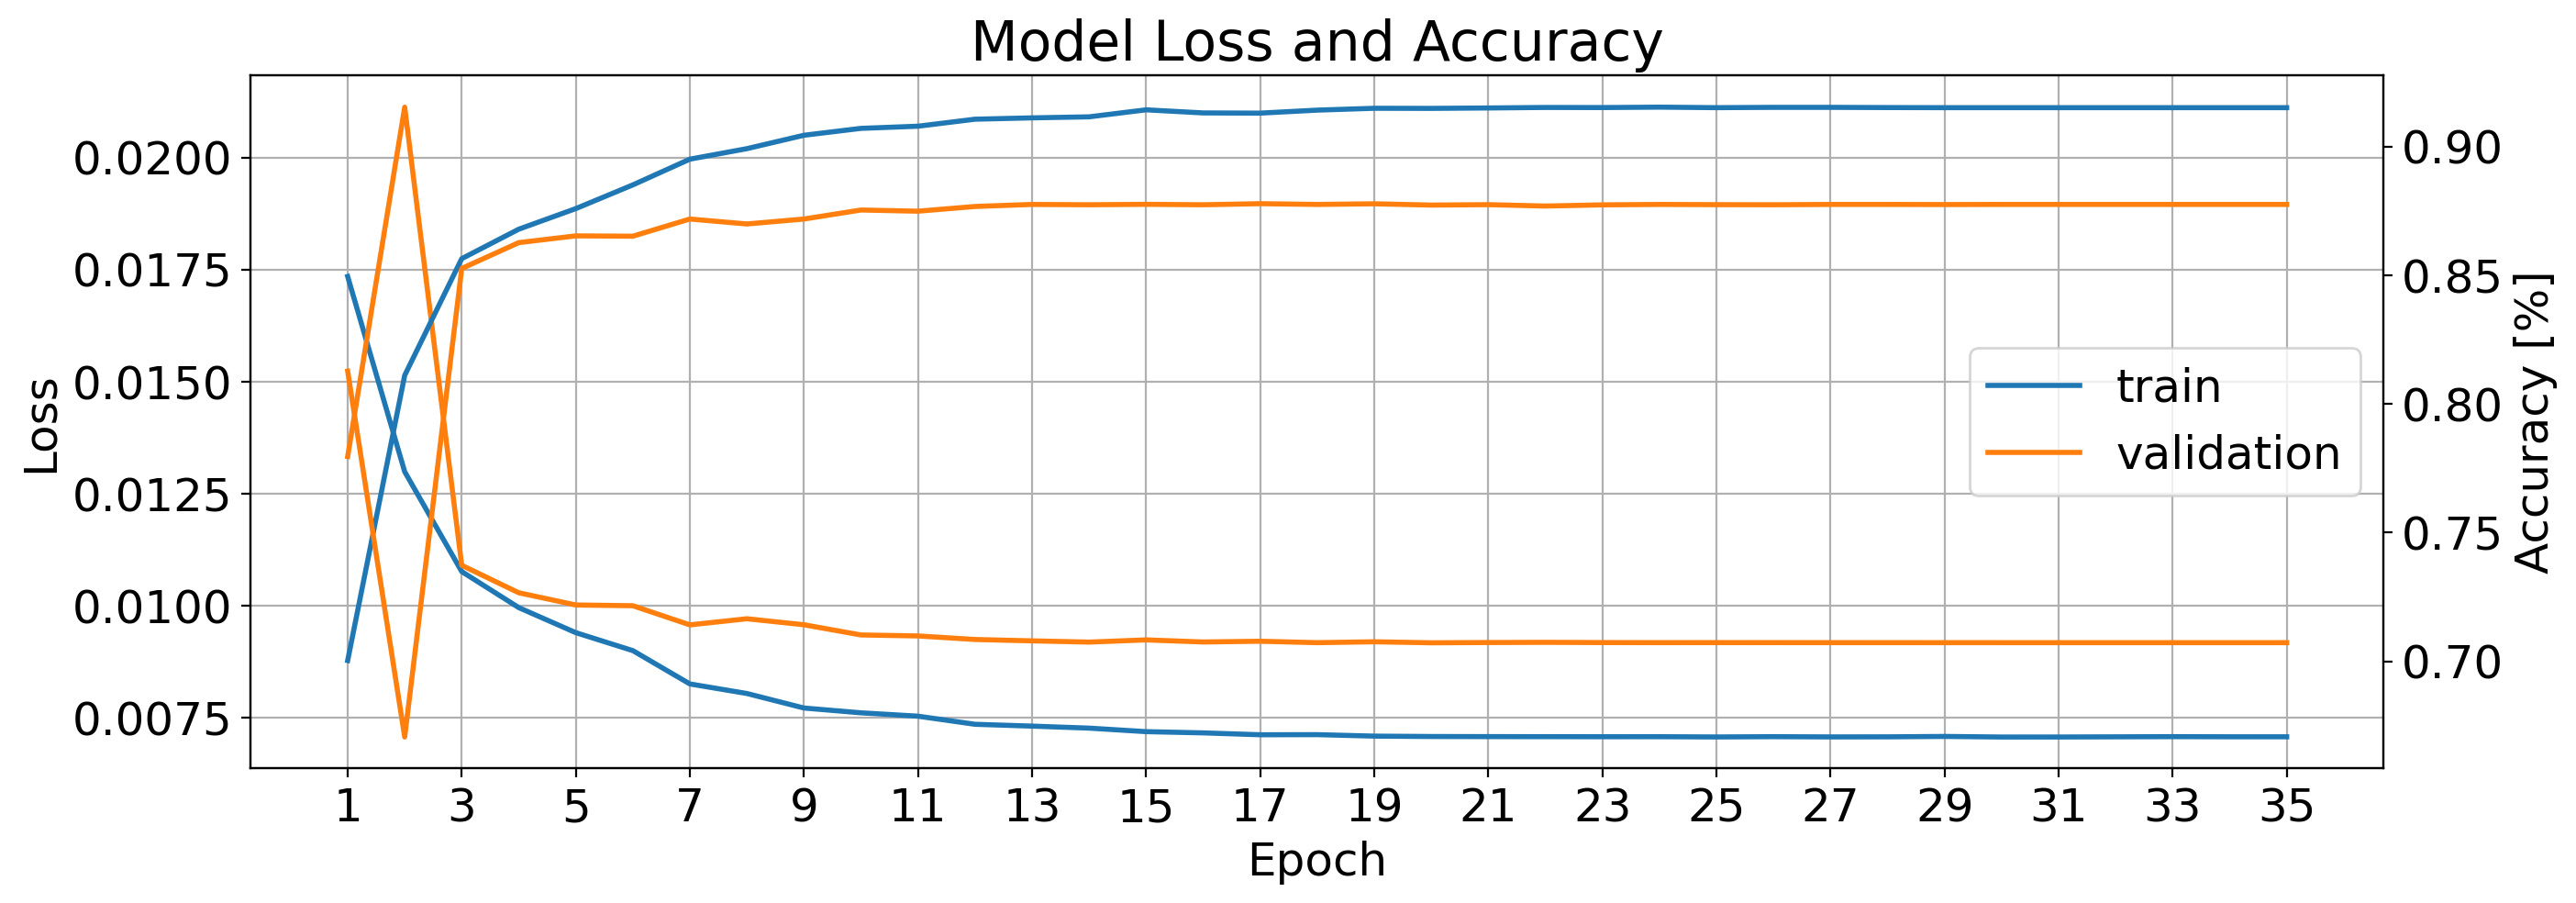

In [44]:
import matplotlib.pylab as plt
from pylab import rcParams
rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')

# plot loss
p1 = ax.plot(logger.logger['epochs'], logger.logger['train_loss'], linewidth=2, label='train')
p2 = ax.plot(logger.logger['epochs'], logger.logger['valid_loss'], linewidth=2, label='validation')
ax.set_xticks(range(1, EPOCHS + 1, 2))
ax.set_xticklabels(range(1, EPOCHS + 1, 2))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss and Accuracy')
ax.xaxis.grid()
ax.yaxis.grid()
ax.legend(loc='center right')

ax1 = ax.twinx()
# plot accuracy
p3 = ax1.plot(logger.logger['epochs'], logger.logger['train_acc'], linewidth=2, label='train\naccuracy')
p4 = ax1.plot(logger.logger['epochs'], logger.logger['valid_acc'], linewidth=2, label='validation\naccuracy')
ax1.set_ylabel('Accuracy [%]')

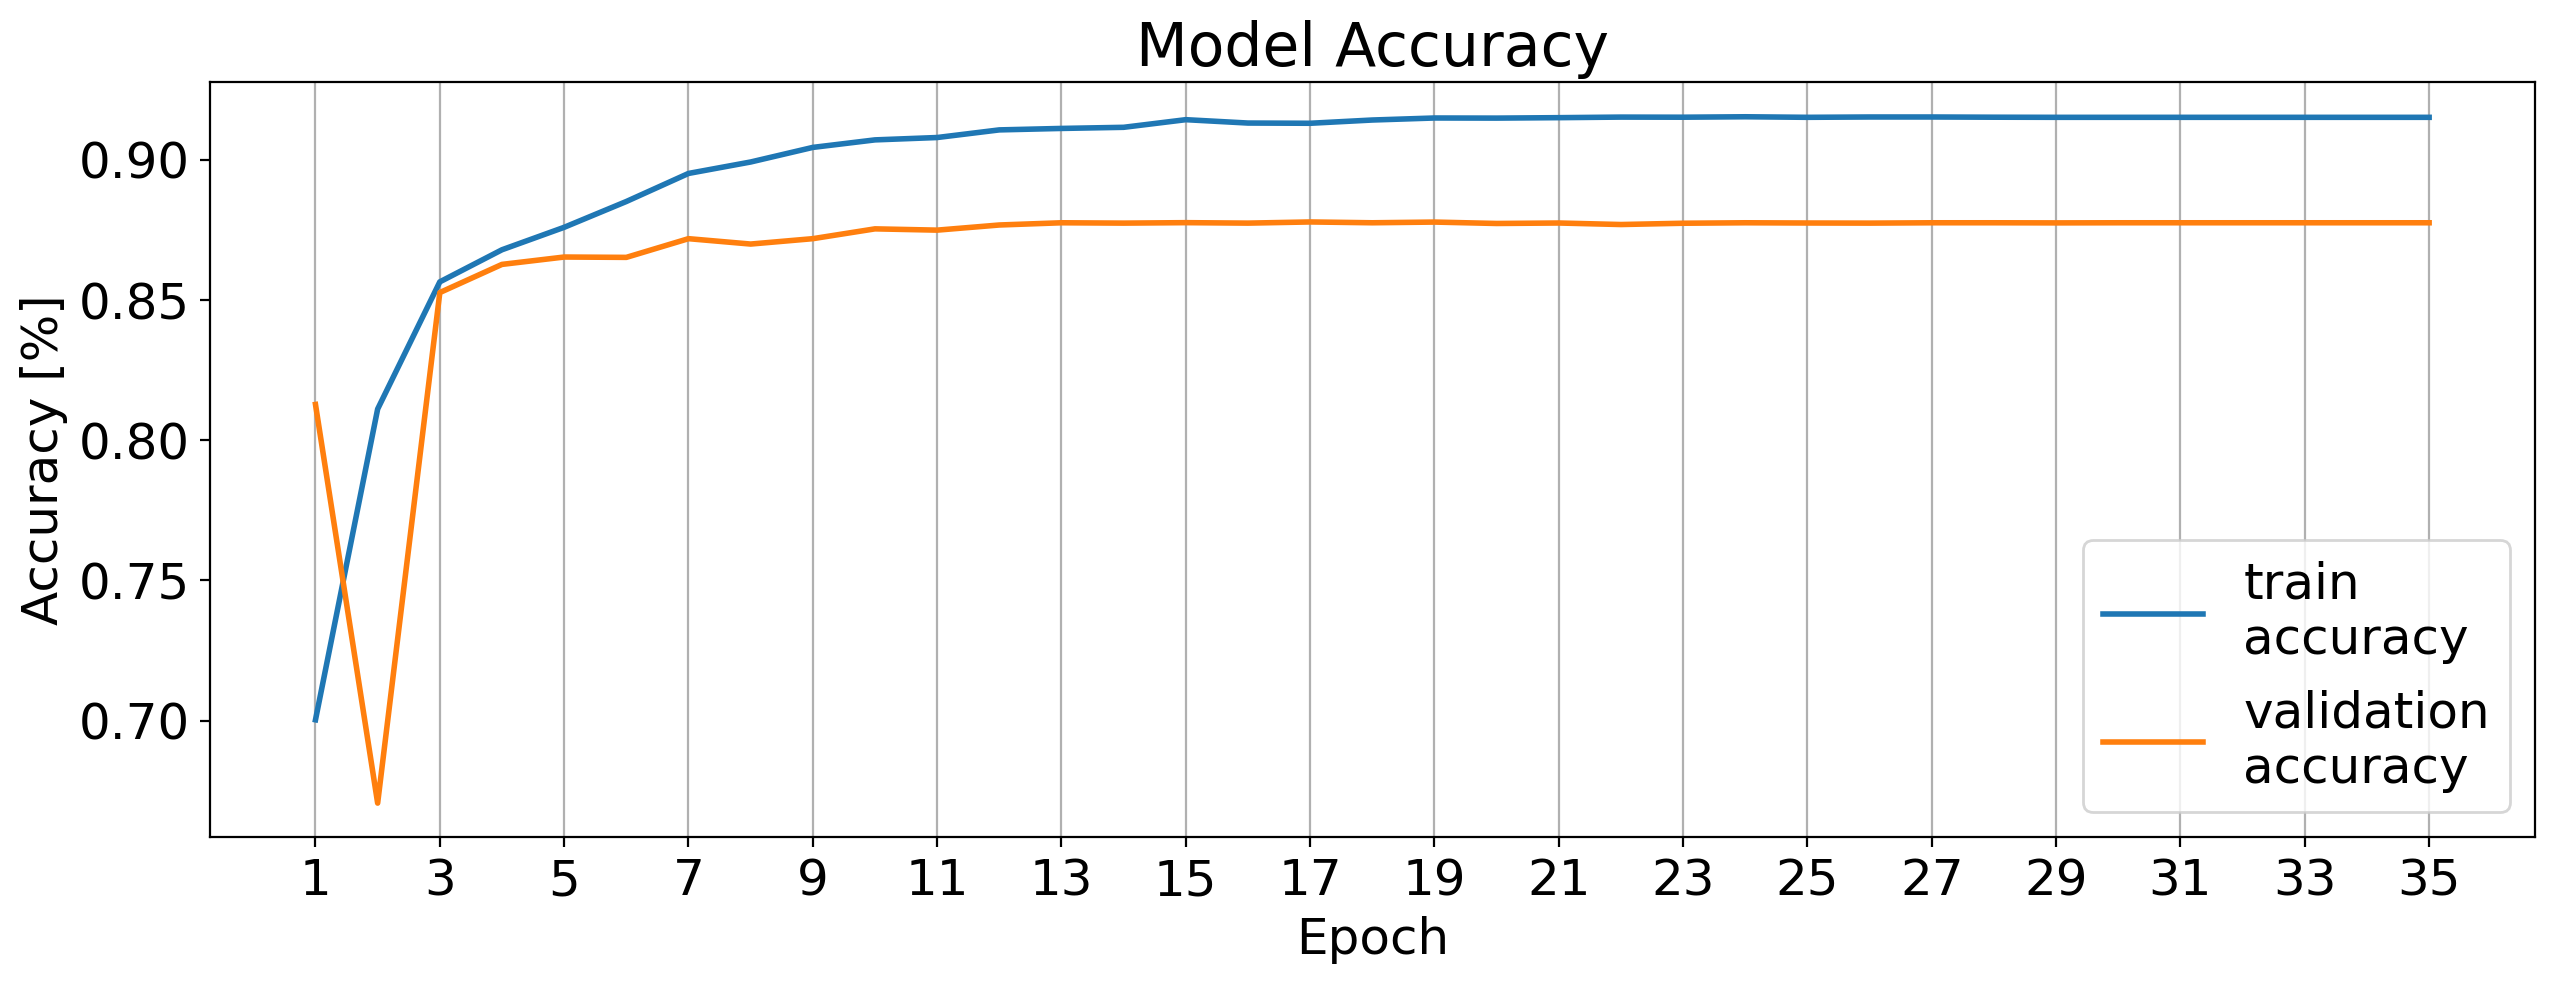

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')

# plot accuracy
p3 = ax.plot(logger.logger['epochs'], logger.logger['train_acc'], linewidth=2, label='train\naccuracy')
p4 = ax.plot(logger.logger['epochs'], logger.logger['valid_acc'], linewidth=2, label='validation\naccuracy')
ax.set_xticks(range(1, EPOCHS + 1, 2))
ax.set_xticklabels(range(1, EPOCHS + 1, 2))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy [%]')
ax.set_title('Model Accuracy')
ax.xaxis.grid()
ax.legend()

# Predict
---

#### Calculating accuracy for the test with sampling datasets

In [28]:
test_with_sampling_accs = []
print('TEST WITH SAMPLING ACCURACIES:\n')
for i, test_dataset in enumerate(test_datasets_with_sampling):
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, collate_fn=collate_batch)
    print(f'Checking the results of TEST dataset with data - {summary_columns_with[i]}:')
    accu_test = evaluate(test_dataloader)
    test_with_sampling_accs.append(accu_test)
    print('accuracy {:8.3f}'.format(accu_test))

TEST WITH SAMPLING ACCURACIES:

Checking the results of TEST dataset with data - text:
accuracy    0.891
Checking the results of TEST dataset with data - summary-100:
accuracy    0.779
Checking the results of TEST dataset with data - summary-90:
accuracy    0.760
Checking the results of TEST dataset with data - summary-80:
accuracy    0.772
Checking the results of TEST dataset with data - summary-70:
accuracy    0.729
Checking the results of TEST dataset with data - summary-60:
accuracy    0.761
Checking the results of TEST dataset with data - summary-50:
accuracy    0.736
Checking the results of TEST dataset with data - summary-40:
accuracy    0.704
Checking the results of TEST dataset with data - summary-30:
accuracy    0.676
Checking the results of TEST dataset with data - summary-20:
accuracy    0.630


#### Calculating accuracy for the test without sampling datasets

In [29]:
test_without_sampling_accs = []
print('TEST WITHOUT SAMPLING ACCURACIES:\n')
for i, test_dataset in enumerate(test_datasets_without_sampling):
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, collate_fn=collate_batch)
    print(f'Checking the results of TEST dataset with data - {summary_columns_without[i]}:')
    accu_test = evaluate(test_dataloader)
    test_without_sampling_accs.append(accu_test)
    print('accuracy {:8.3f}'.format(accu_test))

TEST WITHOUT SAMPLING ACCURACIES:

Checking the results of TEST dataset with data - text:
accuracy    0.891
Checking the results of TEST dataset with data - summary-100:
accuracy    0.770
Checking the results of TEST dataset with data - summary-90:
accuracy    0.773
Checking the results of TEST dataset with data - summary-80:
accuracy    0.782
Checking the results of TEST dataset with data - summary-70:
accuracy    0.776
Checking the results of TEST dataset with data - summary-60:
accuracy    0.738
Checking the results of TEST dataset with data - summary-50:
accuracy    0.710
Checking the results of TEST dataset with data - summary-40:
accuracy    0.699
Checking the results of TEST dataset with data - summary-30:
accuracy    0.676
Checking the results of TEST dataset with data - summary-20:
accuracy    0.610


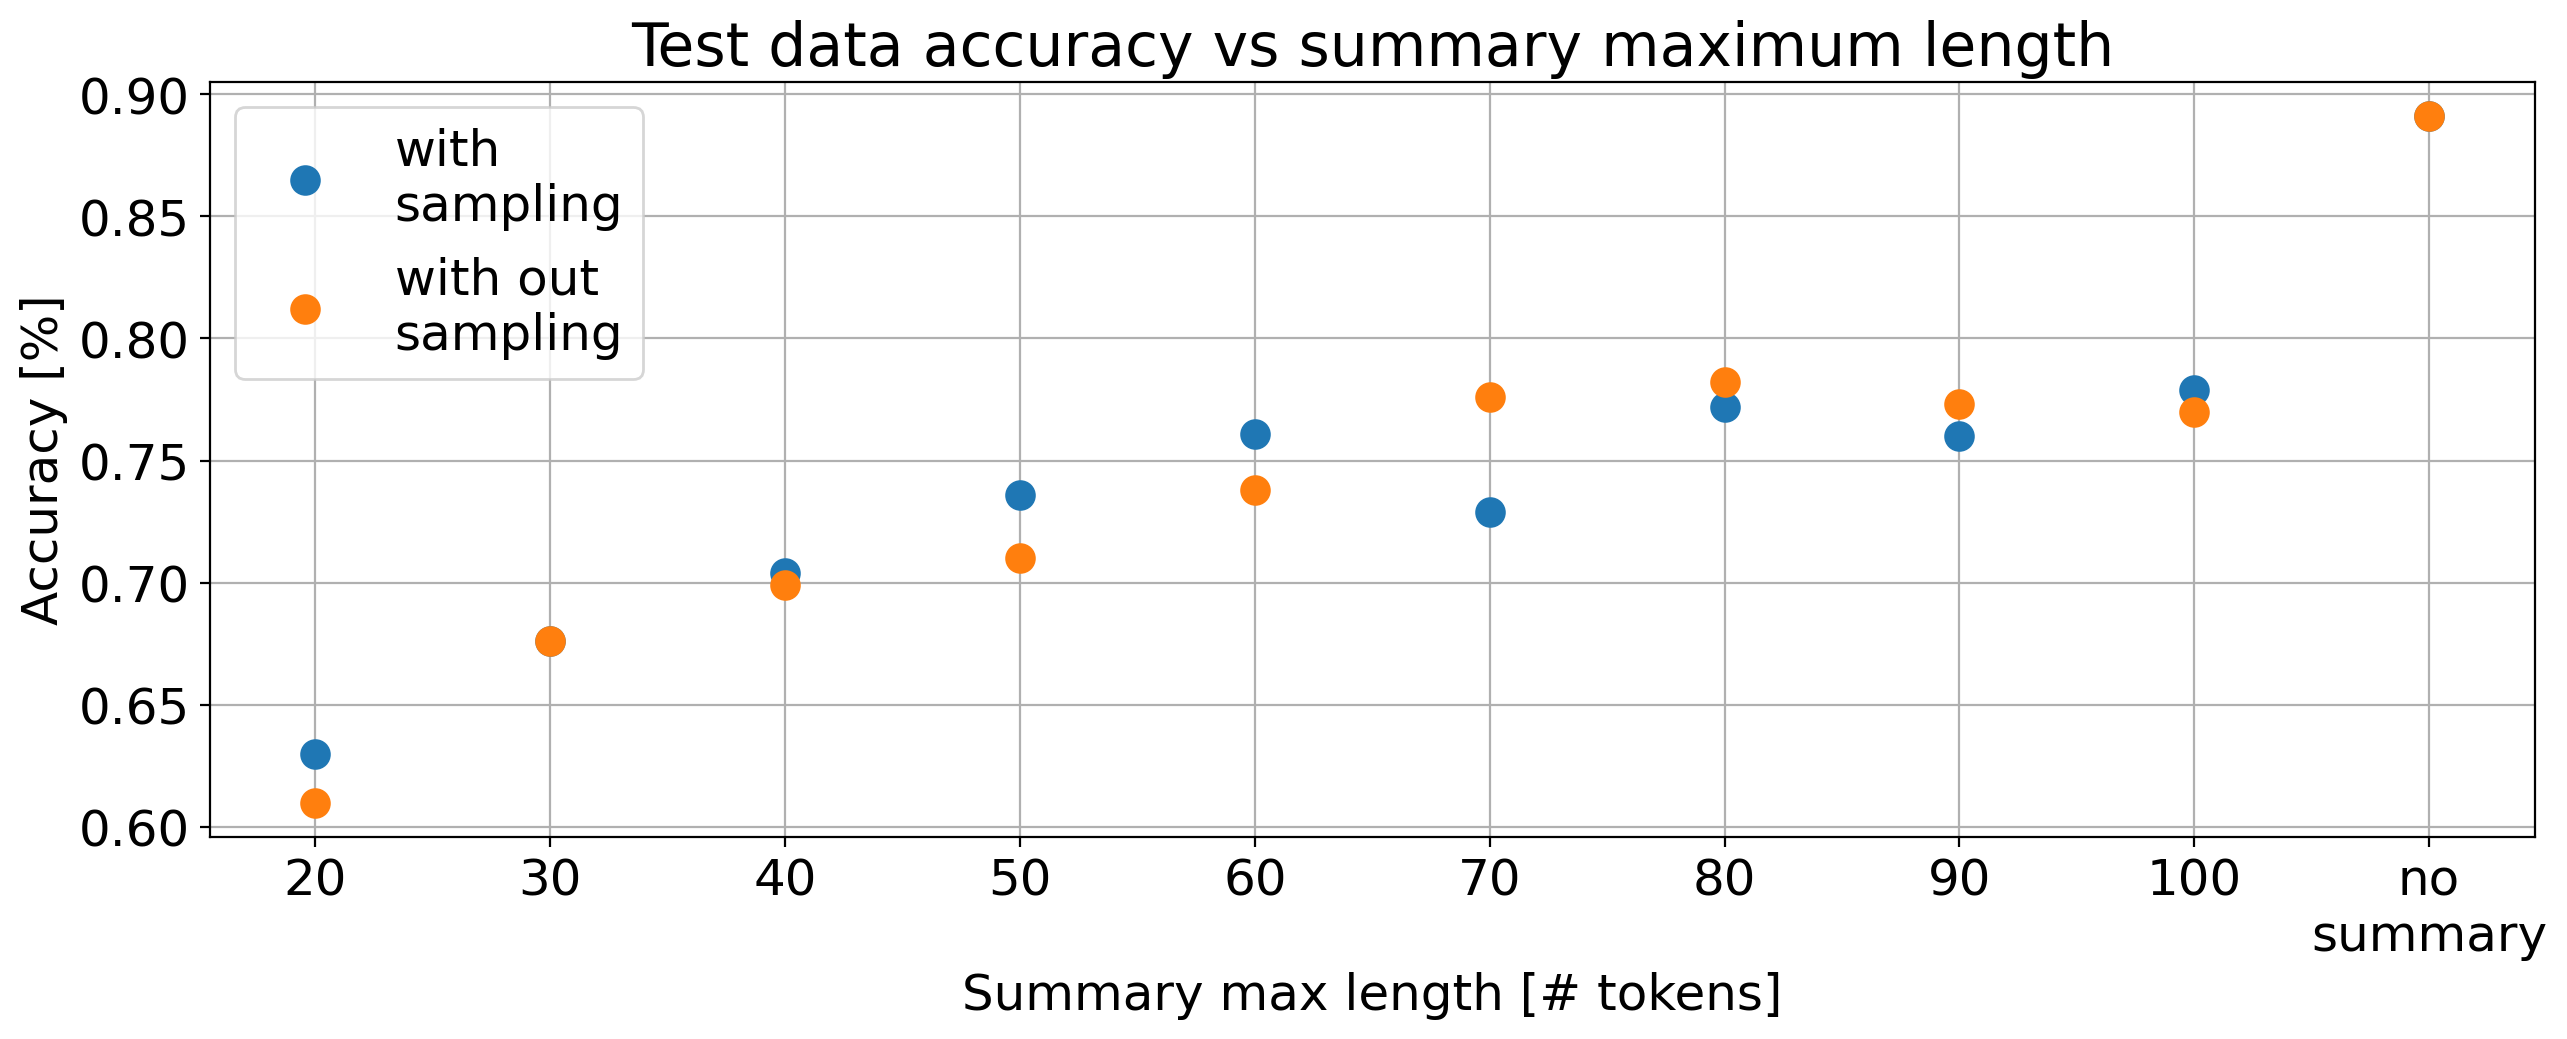

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')
sum_lengths = [110, 100, 90, 80, 70, 60, 50, 40, 30, 20]

# plot accuracy
p3 = ax.plot(sum_lengths, test_with_sampling_accs, 'o', ms=10, linewidth=2, label='with\nsampling')
p4 = ax.plot(sum_lengths, test_without_sampling_accs, 'o', ms=10, linewidth=2, label='with out\nsampling')
ax.set_xlabel('Summary max length [# tokens]')
ax.set_ylabel('Accuracy [%]')
ax.set_xticks(sum_lengths)
ax.set_xticklabels(['no\nsummary', 100, 90, 80, 70, 60, 50, 40, 30, 20])
ax.set_title('Test data accuracy vs summary maximum length')
ax.xaxis.grid()
ax.yaxis.grid()
ax.legend()

In [ ]:
imdb_label = {0: 'negative',
              1: 'positive'}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_positive_str = "Full of suspense, gripping the entire time, intense, \
  two stories in parallel that come together, somewhat predictable betrayals \
   and twist, felt a bit dark at times, satisfying ending, not a huge amount \
    of action but a solid storyline that keeps you on edge."

ex_negative_str = "This is not your traditional Guy Ritchie movie with slick \
   fast paced action, clever humour and lots of twists. Which I have loved in \
    the past. It is basically a combination of heist movie and revenge \
     thriller. But it's played very straight, without a lot of effort to \
      build characters, and doesn't ever seem to build much momentum. So \
       a few times during the movie I found myself looking at my watch, \
        wondering if it was really going anywhere. The action is fairly \
         tight but mainly gunplay, not much physical action as Statham is \
          famous for. There are no heroes either, Stathams character seems  \
          to be a pretty nasty piece of work himself. All in all, it's an \
           average thriller with nothing in particular to recommend it."

model = model.to("cpu")

print("This is a %s review" %imdb_label[predict(ex_positive_str, text_pipeline)])

This is a positive review
